# Differentiable Fluid Simulations

<br>

**TODO , NEXT finish opt case, diverges? see colab example , finish texts before end.**
integration done!

**(older: Differentiable_Fluid_Simulations_with_phiflow2_test)**

<br><br>



Next, we'll target a more complex example with the Navier-Stokes equations as model. We'll target a 2D case with velocity $\mathbf{u}$, no explicit viscosity term, and a marker density $d$ that drives a simple Boussinesq buoyancy term $\eta d$ adding a force along the y dimension:

$\begin{aligned}
  \frac{\partial u_x}{\partial{t}} + \mathbf{u} \cdot \nabla u_x &= - \frac{1}{\rho} \nabla p 
  \\
  \frac{\partial u_y}{\partial{t}} + \mathbf{u} \cdot \nabla u_y &= - \frac{1}{\rho} \nabla p + \eta d
  \\
  \text{s.t.} \quad \nabla \cdot \mathbf{u} &= 0,
  \\
  \frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d &= 0 
\end{aligned}$

As optimization objective we'll consider a more difficult variant of the previous example: the state of the observed density $d$ should match a given target after $n=20$ steps of simulation. In contrast to before, the marker $d$ cannot be modified in any way, but only the initial state of the velocity $\mathbf{u}$ at $t=0$. This gives us a split between observable quantities for the loss formulation, and quantities that we can interact with during the optimization (or later on via NNs).

First, let's get the loading of python modules out of the way. By importing `phi.tf.flow` below, we get fluid simulation functions that work within tensorflow graphs and can provide gradients.

In [1]:
#!pip install --upgrade --quiet phiflow
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.tf.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab

/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])


## Batched Simulations

Now we can setup the simulation, which will work in line with the previous "regular" simulation example from the {doc}`overview-ns-forw`. However, now we'll directly include an additional dimension, in line with a mini-batch used for NN training. For this, we'll include an additional named dimension called `inflow_loc`. This dimension will exist "above" the previous spatial dimensions `x`, `y` and the channel dimensions `vector`. As indicated by the name `inflow_loc`, the main differences for this dimension will lie in different locations of the inflow, in order to obtain different flow simulations. The named dimensions in phiflow make it very convenient to broadcast information

The `Domain` object is allocated just like before, but the `INFLOW_LOCATION` tensor now receives a string
`'inflow_loc,vector'` that indicates the names of the two dimensions.


In [2]:
DOMAIN = Domain(x=32, y=40, boundaries=CLOSED, bounds=Box[0:32, 0:40])

INFLOW_LOCATION = math.tensor([(10, 5), (12, 5), (14, 5), (16, 5)], 'inflow_loc,vector', convert=True)
INFLOW = DOMAIN.grid(Sphere(center=INFLOW_LOCATION, radius=3)) * (1./3.)
print(f"Inflow tensor shape and dimensions: {INFLOW.shape}")


Inflow tensor shape and dimensions: (inflow_loc=4, x=32, y=40)


The last `print` verifies that our `INFLOW` grid likewise has an `inflow_loc` dimension in addition to the two spatial ones. You can test for the existence of a tensor dimension in phiflow with the `.exists` boolean, which can be evaluated for any dimension name. E.g., above `INFLOW.inflow_loc.exists` will give `True`, while `INFLOW.unknown_dim.exists` will give `False`.


We can easily simulate a few steps now starting with these different initial conditions. Thanks to the broadcasting, the exact same code we used for the single forward simulation in the overview chapter will produce four simulations with different smoke inflow positions.

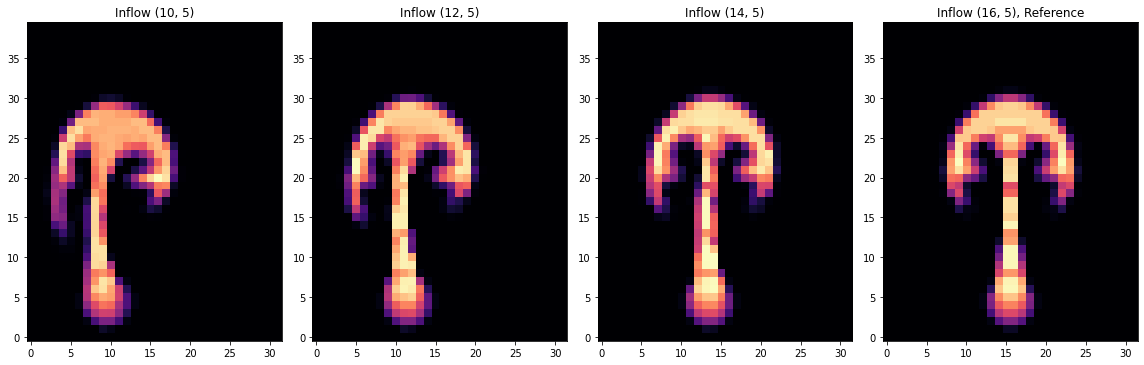

In [3]:
smoke = DOMAIN.scalar_grid(0)        # sampled at cell centers
velocity = DOMAIN.staggered_grid(0)  # sampled in staggered form at face centers 

def step(smoke, velocity):
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
  buoyancy_force = smoke * (0, 1) >> velocity
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _, _, _ = fluid.make_incompressible(velocity, DOMAIN)
  return smoke, velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  axes[i].imshow(smoke.values.inflow_loc[i].numpy('y,x'), origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}" + (", Reference" if i==3 else ""))
pylab.tight_layout()



The last image shows the state of the advected smoke fields after 20 simulation steps. The final smoke shape of simulation `[3]` with an inflow at `(16,5)`, with the straight plume on the far right, will be our **reference state** below. The initial velocity of the other three will be modified in the optimization procedure below to match this reference.

(A small side hint: phiflow tensors will keep track of their chain of operations using the backend they were created for. E.g. a tensor created with NumPy will keep using NumPy/SciPy operations unless a TensorFlow tensor is also passed to the same operation. Thus, it is a good idea to verify that tensors have the right `type` once in a while.)


## Gradients

Let's look at how to get gradients from our simulation. The first trivial step taken care of above was to include `phi.tf.flow` to import differentiable operators from which to build our simulator.

Now we want to optimize the initial velocities so that all simulations arrive at a final state that is similar to the right simulation where the inflow is located at `(16, 5)`.
To achieve this, we record the gradients during the simulation and define a simple $L^2$ based loss function. The loss function we'll use is given by $L = | s - s_r |^2$, where $s$ denotes the smoke density, and $s_r$ the reference state from the fourth simulation above. When evaluating the loss function we treat this reference state as an external constant via `field.stop_gradient()`.

It is important that our initial velocity has the `inflow_loc` dimension before we record the gradients, such that we have the full "mini-batch" of four versions of our velocity (three of which will be updated via gradients in our optimization later on). To get the approprate velocity tensor, we multiply a `staggered_grid` tensor from our domain object, with a tensor full of ones along the `inflow_loc` dimension.

In [4]:
smoke = DOMAIN.grid(math.zeros(inflow_loc=4))
velocity = initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)
print("Velocity tensor shape: "+format(velocity.shape))

with math.record_gradients(initial_velocity.values):
    for _ in range(5):
        smoke,velocity = step(smoke,velocity)

    loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]))
    grad = math.gradients(loss, initial_velocity.values)


Velocity tensor shape: (inflow_loc=4, x=32, y=40, vector=2)
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Computing the actual gradient is not very difficult. We simply call `math.gradients` for the initial velocity w.r.t. our loss function to obtain the `grad` tensor.

Let's direcly take a look at it. The following images show the `x` components (via `vector[0]`) of the staggered grid gradient in `grad`.

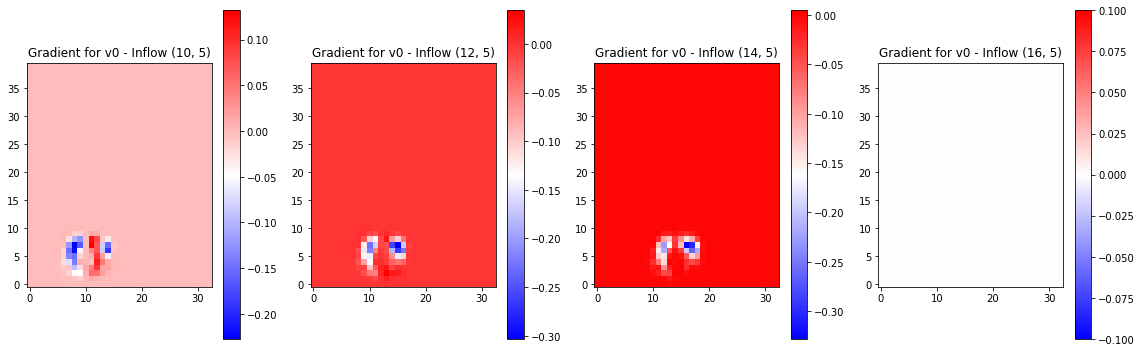

In [5]:
fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  im = axes[i].imshow(grad.inflow_loc[i].vector[0].numpy('y,x'), origin='lower', cmap='bwr')
  pylab.colorbar(im, ax=axes[i])
  axes[i].set_title(f"Gradient for v0 - Inflow {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}")
pylab.tight_layout()


Not surprisingly, the fourth gradient on the left is zero (it's already matching the reference). The other three gradients have detected variations for the intial round inflow posiitons shown as positive and negative regions around the cirucular shape.

This is just the linearized change that is points in the direction of an increasing loss. Now we can proceed by updating the initial velocities in the opposite direction to minimize the loss.

Note that this is a fairly tough task: we're producing different dynamics by changing the boundary conditions (the marker inflow position), and an optimizer should now find a single initial velocity state for each of the three simulations on the right, that gives the same state as simulation `0` above at $t=20$. Thus, after 20 update steps the simulation should reproduce a different set of boundary conditions from the velocity state. It would be much easier to simply change the position of the marker inflow to arrive at this goal, but -- to make things a bit more difficult and interesting here -- the inflow is _not_ a degree of freedom. The optimizer can only change the velocity $\mathbf{u}$ at time $t=0$.

The following cell re-starts the simulations, and iterates a few times to optimize the initial velocities.

In [7]:
initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)
LR = 1e-02

for _ in range(10):
    velocity = initial_velocity
    smoke = DOMAIN.grid(math.zeros(inflow_loc=4)) + INFLOW

    with math.record_gradients(initial_velocity.values):

        buoyancy_force = smoke * (0, 1) >> velocity
        velocity, _, _, _ = fluid.make_incompressible(velocity + buoyancy_force, DOMAIN)
        for _ in range(20):
            smoke,velocity = step(smoke,velocity)

        loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[0]))
        print(format(loss))
        grad = math.gradients(loss, initial_velocity.values)
    initial_velocity = initial_velocity - LR * grad


65.591805
65.37787
65.1976
64.12548
64.667114
64.404465
74.69762
76.985146
78.58485
82.51491


The loss should have gone down significantly, from above 60 to below 40, and now we can visualize how well the reconstruction for the last frame turned out for simulations 0 to 2.

In [ ]:
fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  im = axes[i].imshow(grad.inflow_loc[i].vector[0].numpy('y,x'), origin='lower', cmap='bwr')
  pylab.colorbar(im, ax=axes[i])
  axes[i].set_title(f"Gradient for v0 - Inflow {math.to_int(INFLOW_LOCATION).inflow_loc[i].vector.unstack_spatial('x,y')}")
pylab.tight_layout()

Naturally, the image on the right is the same (this is simulation (3), our reference), and the other three simulations now exhibit a noticeable shift towards the right. 

**XXX TODO** This is especially visible for the far right simulation (3), which was moving straight up in its original state, and now has an off-center plume shape that tries to match the reference on the left. 

Note that all three simulations need to "work" with a fixed inflow, hence they cannot simply "produce" marker density out of the blue to match the target. Also each simulation needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. So the optimization goal is quite difficult, and it is not possible to exactly satisfy the constraints to match the reference simulation in this scenario. This is exactly what makes it an interesting test case, though.

**XXX TODO**  Now we can also have a look at the now-optimized initial velocity field. Here we see the y-components (from `data[...,0]`).

... re-simulate 

In [ ]:
# re-run sim
smoke = DOMAIN.grid(math.zeros(inflow_loc=4)) + INFLOW
velocity = initial_velocity
buoyancy_force = smoke * (0, 1) >> velocity
velocity, _, _, _ = fluid.make_incompressible(velocity + buoyancy_force, DOMAIN)

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
for i in range(INFLOW.shape.inflow_loc):
  axes[i].imshow(smoke.values.inflow_loc[i].numpy('y,x'), origin='lower', cmap='magma')


This example illustrates how the differentiable physics approach can easily be extended towards significanlty more complex PDEs. Above, we've optimized for a mini-batch of 20 steps of a full Navier-Stokes solver.

This is a powerful basis to bring NNs into the picture! As you might have noticed, our degrees of freedom were still a regular grid, and we've solved a single inverse problem. There was more than one case to solve, but nonetheless no question of generalization and no neural network structure.

















<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>


--- 

## END UP TO HERE , REMOVE REST?


In [ ]:
xxx

#use keras GD?

# "reset" necessary???
#smoke = DOMAIN.grid(math.zeros(inflow_loc=4))
if 0:
    velocity = initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)
    smoke = DOMAIN.grid(math.zeros(inflow_loc=4)) + INFLOW

    with math.record_gradients(initial_velocity.values):
        buoyancy_force = smoke * (0, 1) >> velocity
        velocity, _, _, _ = fluid.make_incompressible(velocity + buoyancy_force, DOMAIN)
        for _ in range(2):
            smoke,velocity = step(smoke,velocity)

        loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]))
        print(format(loss))    
        grad = math.gradients(loss, initial_velocity.values)
        print(type(grad))

    print("ok")
# ---

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
opt = tf.keras.optimizers.SGD(learning_rate=1e-02)
#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    
velocity = initial_velocity = DOMAIN.staggered_grid(0) * math.ones(inflow_loc=4)
smoke = DOMAIN.grid(math.zeros(inflow_loc=4)) + INFLOW

#with math.record_gradients(initial_velocity.values): # PHI
with tf.GradientTape() as tape: # same
    buoyancy_force = smoke * (0, 1) >> velocity
    velocity, _, _, _ = fluid.make_incompressible(velocity + buoyancy_force, DOMAIN)
    for _ in range(2):
        smoke,velocity = step(smoke,velocity)

    loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]))
    #print(type(loss.native()))
    print("Loss "+format(loss))
    
    #grad = math.gradients(loss, initial_velocity.values) # PHI
    
    #print(type(grad.vector[0]))
    print(type(grad.vector[0].native()))
    #print(format(grad.vector[0].shape))
    print(type(initial_velocity.vector[0].values.native()))
    #print(format(initial_velocity.vector[0].shape))

    grads = tape.gradient(loss.native(), [initial_velocity.vector[0].values.native()] ) # works
    
    # a = grad.vector[0].native() + initial_velocity.vector[0].values.native()  # works PHI
    #opt.apply_gradients(zip([grad.vector[0].native()], [initial_velocity.vector[0].values.native()] ))

    opt.apply_gradients(zip(grads, [initial_velocity.vector[0].values.native()] ))
    # -> same error as opt.minimize?
    
    # minimize:
    #lossL = lambda: (field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]))).native()
    #opt.minimize(lossL, [initial_velocity.vector[0].values.native()])



#initial_velocity = initial_velocity - 1e-02 * grad
#step_count = opt.minimize(loss, [var1]).numpy()
#step_count = opt.minimize(loss, [initial_velocity.values.native()]).numpy()

#print(step_count)



In [ ]:
...

In [ ]:


















xxx UP TO HERE xxx


world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05, batch_size=4), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=centers, radius=3), rate=0.2));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
initial_state = fluid.state  # Remember the state at t=0 for later visualization
session.initialize_variables()

The simulation now contains variables in the initial state.
Since all later states depend on the value of the variable, the `step` method cannot directly compute concrete state values.
Instead, `world.step` will extend the TensorFlow graph by the operations needed to perform the step.

To execute the graph with actual data, we can use `session.run`, just like with regular TensorFlow 1.x. While `run` would usually be used to infer predictions from a learning model, it now executes the graph of simulation steps.

In [ ]:
world.step()
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

Let's build a graph for the full simulation.

In [ ]:
for step in range(20):
  print('Building graph for time step %d' % step)
  world.step(dt=1.5)

When calling `session.run` now, the full simulation is evaluated using TensorFlow operations.
This will take advantage of your GPU, if available.
If you compile Φ<sub>Flow</sub> with [CUDA support](https://github.com/tum-pbs/PhiFlow/blob/master/documentation/Installation_Instructions.md), the TensorFlow graph will also use optimized operators for efficient simulation and training runs.

The `session.run()` call of the following code block will now retrieve the final fluid density, and for that it actually needs to process all 20 simulation steps of the TF graph that we just constructed.

In [ ]:
print('Computing frames...')
original_state = np.concatenate(session.run(fluid.density).data[...,0], axis=1)
pylab.imshow(original_state, origin='lower', cmap='magma')

Next, we define the *loss* function. This is the value we want to decrease via optimization.
For this example, we want the marker densities of all final simulation states to match the left-most one, called `target`, in terms of an $L^2$ norm.

For the optimizer, we choose again gradient descent for this example.

In [ ]:
target = session.run(fluid.density).data[0,...]
loss = math.l2_loss(fluid.density.data[1:,...] - target)
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
session.initialize_variables()

print('Initial loss: %f' % session.run(loss))

With the loss and optimizer set up, all that's left is to run the actual optimization.

In [ ]:
for optim_step in range(100):
    _, loss_value = session.run([optim, loss])
    if optim_step<3 or optim_step%10==0: 
        print('Optimization step %d, loss %f %s' % (optim_step, loss_value, '' if optim_step else '. The first step sets up the adjoint graph.'))


The loss should have gone down significantly, from above 60 to below 40, and now we can visualize how well the reconstruction for the last frame turned out for simulations 1 to 3.

In [ ]:
optimized_state = np.concatenate(session.run(fluid.density).data[...,0], axis=1)
pylab.title("Original state at t=20 (top), and optimized version (bottom):")
pylab.imshow( np.concatenate([optimized_state, original_state],axis=0), origin='lower', cmap='magma')

Naturally, the image on the left is the same (this is simulation (0), our reference), and the other three simulations now exhibit a noticeable curved shape towards the left. This is especially visible for the far right simulation (3), which was moving straight up in its original state, and now has an off-center plume shape that tries to match the reference on the left. 

Note that this simulation (like both others) needs to "work" with a fixed inflow, hence it cannot simply "produce" marker density out of the blue to match the target. Also it needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. So the optimization goal is quite tough, and it is not possible to exactly satisfy the constraints to match simulation (0) in this scenario. This is exactly what makes it an interesting test case, though.

Now we can also have a look at the now-optimized initial velocity field. Here we see the y-components (from `data[...,0]`).

In [ ]:
optimized_velocity_field = session.run(initial_state.velocity).at_centers()

pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

This nicely shows how the initial perturbation of the velocity field grows for the larger inflow deviations towards the right:

For comlpeteness, here are the x-components:

In [ ]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

This example illustrates how the differentiable physics approach can easily be extended towards significanlty more complex PDEs. Above, we've optimized for a mini-batch of 20 steps of a full Navier-Stokes solver.

This is a powerful basis to bring NNs into the picture! As you might have noticed, our degrees of freedom were still a regular grid, and we've solved a single inverse problem. There was more than one case to solve, but nonetheless no question of generalization and no neural network structure.